In [ ]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.3 MB/s eta 0:00:00


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.7 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=1c1a5f5787f68ad4dcb667eacb0287569ca5b1ca15fb74a8179982dc34ac7930
  Stored in directory: /root/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge_score


In [ ]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from nltk.tokenize import sent_tokenize,word_tokenize
from datasets import load_dataset,load_metric, DatasetDict
import numpy as np
import pandas as pd
import networkx as nx
import re
import rouge
import seaborn as sns
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
metric = load_metric('rouge')

<ipython-input-8-10e4a614ebd6>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('rouge')


In [ ]:
def get_rouge(y_test, y_pred):
    rouge_score = rouge.Rouge()
    scores = rouge_score.get_scores(y_test, y_pred, avg=True)
    score_1 = round(scores['rouge-1']['f'], 2)
    score_2 = round(scores['rouge-2']['f'], 2)
    score_L = round(scores['rouge-l']['f'], 2)
    print("rouge1:", score_1, "| rouge2:", score_2, "| rougeL:", score_2, 
          "--> avg rouge:", round(np.mean([score_1,score_2,score_L]), 2))


In [ ]:
def add_text_length(data, column):
    df = data.copy()
    df['word_count'] = df[column].apply(lambda x: len(word_tokenize(str(x))) )
    df['char_count'] = df[column].apply(lambda x: sum(len(word) for word in word_tokenize(str(x))) )
    df['sentence_count'] = df[column].apply(lambda x: len(sent_tokenize(str(x))) )
    df['avg_word_length'] = df['char_count'] / df['word_count']
    df['avg_sentence_lenght'] = df['word_count'] / df['sentence_count']
    print(df[['char_count','word_count','sentence_count','avg_word_length','avg_sentence_lenght']].describe().T[["min","mean","max"]])
    return df

In [ ]:

train_data = load_dataset("csv", data_files='./processed-data/train.csv')
val_data = load_dataset("csv", data_files='./processed-data/val.csv')
data = DatasetDict({
    'train':train_data['train'],
    'validation':val_data['train']
})


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c459144453100168/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-49b2e1b910715c0d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

                           min         mean          max
char_count           41.000000  3338.996688  9725.000000
word_count           10.000000   785.899063  2171.000000
sentence_count        1.000000    39.005313   304.000000
avg_word_length       2.728710     4.266339     6.404396
avg_sentence_lenght   5.986842    21.563718    44.800000


<ipython-input-12-e00987fe257a>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(article_length_info['word_count'], hist=True, kde=True, kde_kws={"shade":True})
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


<Axes: xlabel='word_count', ylabel='Density'>

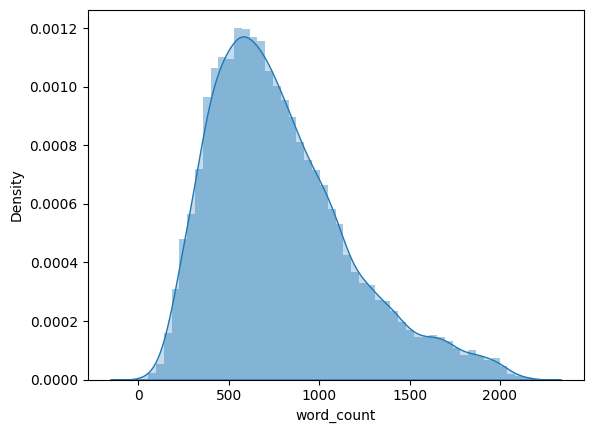

In [ ]:
article_length_info = add_text_length(pd.DataFrame(data['train']), "article")
sns.distplot(article_length_info['word_count'], hist=True, kde=True, kde_kws={"shade":True})


                           min        mean          max
char_count           25.000000  245.244438  1865.000000
word_count            4.000000   54.858500   498.000000
sentence_count        1.000000    3.692813    55.000000
avg_word_length       2.363636    4.502701     7.222222
avg_sentence_lenght   4.000000   15.186781   115.000000


<ipython-input-13-90228ae9b026>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(summary_length_info['word_count'], hist=True, kde=True, kde_kws={"shade":True})
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


<Axes: xlabel='word_count', ylabel='Density'>

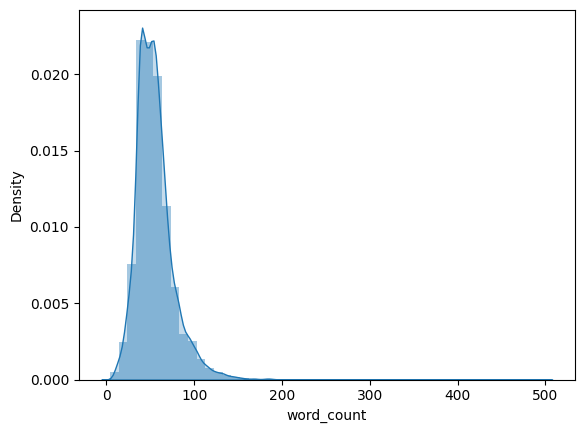

In [ ]:
summary_length_info = add_text_length(pd.DataFrame(data['train']), "summary")
sns.distplot(summary_length_info['word_count'], hist=True, kde=True, kde_kws={"shade":True})


In [ ]:
max_len_article = 600
max_len_summary = 50

In [ ]:
batch_size = 3
model_checkpoints = "facebook/bart-large-xsum"


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoints)

In [ ]:
def preprocess_data(data_to_process):
  #get all the articles
  inputs = [dialogue for dialogue in data_to_process['article']]
  #tokenize the dialogues
  model_inputs = tokenizer(inputs,  max_length=max_len_article, padding='max_length', truncation=True)
  #tokenize the summaries
  with tokenizer.as_target_tokenizer():
    targets = tokenizer(data_to_process['summary'], max_length=max_len_summary, padding='max_length', truncation=True)
    
  #set labels
  model_inputs['labels'] = targets['input_ids']
  #return the tokenized data
  return model_inputs

In [ ]:
tokenize_data = data.map(preprocess_data, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoints)


In [ ]:
collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
def compute_rouge(pred):
  predictions, labels = pred
  #decode the predictions
  decode_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  #decode labels
  decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  #compute results
  res = metric.compute(predictions=decode_predictions, references=decode_labels, use_stemmer=True)
  #get %
  res = {key: value.mid.fmeasure * 100 for key, value in res.items()}

  pred_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
  res['gen_len'] = np.mean(pred_lens)

  return {k: round(v, 4) for k, v in res.items()}

In [ ]:
args = Seq2SeqTrainingArguments(
    'bart-abstractive-summarization',
    evaluation_strategy='epoch',
    learning_rate=2e-4,
    per_device_train_batch_size=3,
    per_device_eval_batch_size= 3,
    gradient_accumulation_steps=3,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    eval_accumulation_steps=3,
    fp16=True 
    )

trainer = Seq2SeqTrainer(
    model, 
    args,
    train_dataset=tokenize_data['train'],
    eval_dataset=tokenize_data['validation'],
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge
)

In [ ]:
trainer.train()


You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.150200,2.111696,34.588100,14.091800,25.017200,31.640900,50.893200
2,1.451500,2.010772,36.536500,15.880300,26.660000,33.718300,50.888200
3,0.865100,2.098510,36.497600,15.501600,26.434400,33.669600,50.663800


TrainOutput(global_step=5334, training_loss=1.5301656190223536, metrics={'train_runtime': 11782.0508, 'train_samples_per_second': 4.074, 'train_steps_per_second': 0.453, 'total_flos': 6.09498169344e+16, 'train_loss': 1.5301656190223536, 'epoch': 3.0})